In [1]:
import os

img = 'data/50salads_image/rgb-01-2'
label = 'MS-TCN2/data/50salads/groundTruth/rgb-01-2.txt'
label_path = os.path.join(os.getcwd(), label)
print("이미지 개수", len(os.listdir(os.path.join(os.getcwd(), img) )))

with open(label_path, 'r') as f:
    lab = f.read().split('\n')
print(len(lab))

이미지 개수 420
12586


In [44]:
import os
import torch
import torch.nn as nn
import numpy as np
import time

from model import get_pretrained_model
from dataset import jpg2np, get_loader
from torchvision import models
from bezier.hazmat.curve_helpers import evaluate_hodograph, get_curvature

In [33]:
x = np.random.rand( 30, 3, 240, 320)
x = torch.from_numpy(x).float()
x.shape

torch.Size([30, 3, 240, 320])

In [54]:
#############################
########  Network   #########
#############################
import bezier 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        
        self.num_frames = 30
        
        self.embedding = vgg16.features
        
        self.spatial = nn.Linear(512, 101)
        self.temporal_1 = nn.Linear(512, 3)
        self.temporal_2 = nn.Linear(3, 1)
        
    def forward(self, x):
        
        embeddings = self.embedding(x)
        embeddings = nn.AdaptiveAvgPool2d((1,1))(embeddings).squeeze() 
        
        temporal_embeddings = self.temporal_1(embeddings)
        
        
        # Predict Img Class
        y1_hat = self.spatial(embeddings)
        
        
        # Predict the Curvature
        y2_hat = self.temporal_2(temporal_embeddings)
        
        
        # Calculate the true Curvature
        temporal_embeddings = temporal_embeddings.detach().numpy()
        curve = self.bezier(temporal_embeddings)

        y2 = self.curvature(temporal_embeddings, curve)
        
        return y1_hat, y2_hat, y2
    
    
    def bezier(self, control_points):
        return bezier.Curve.from_nodes(control_points.T)
    
    
    def curvature(self, embeddings, curve):
        kappa = []
        for s in range(self.num_frames):
            t = s / self.num_frames
            tangent_vec = curve.evaluate_hodograph(t)
            kappa.append(get_curvature(embeddings, tangent_vec, t))
            
        return np.array(kappa).reshape(-1, 1)
    
net = Network()
y1_hat, y2_hat, y2 = net(x)

y1.shape, y2.shape, y2.shape

(torch.Size([30, 101]), (30, 1), (30, 1))

In [2]:
os.getcwd()

'/home/smsm8898/workspace'

In [10]:
import numpy as np

nodes1 = np.asfortranarray([
    [0.0, 0.5, 1.0],
    [0.0, 1.0, 0.0],
])

nodes2 = np.random.rand(3,5)
nodes1, nodes2

(array([[0. , 0.5, 1. ],
        [0. , 1. , 0. ]]),
 array([[0.10857867, 0.91000047, 0.95837665, 0.52487359, 0.15137667],
        [0.24534266, 0.24363021, 0.93275927, 0.92501138, 0.09469432],
        [0.14211507, 0.83182529, 0.14368299, 0.27119706, 0.81995784]]))

In [15]:
v_HorseRace_g07_c06
import bezier
# curve1 = bezier.Curve(nodes1, degree=2)
curve2 = bezier.Curve(nodes2, degree=4)

In [18]:
#############################
########  Network   #########
#############################
import bezier 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        vgg16 = models.vgg16(pretrained=False)
        
        self.num_frames = 30
        
        self.embedding = vgg16.features
        
        self.spatial = nn.Linear(512, 101)
        self.temporal_1 = nn.Linear(512, 3)
        self.temporal_2 = nn.Linear(3, 1)
        
    def forward(self, x):
        try:
            embeddings = self.embedding(x)
            embeddings = nn.AdaptiveAvgPool2d((1,1))(embeddings).squeeze() 

            temporal_embeddings = self.temporal_1(embeddings)


            # Predict Img Class
            y1_hat = self.spatial(embeddings)


            # Predict the Curvature
            y2_hat = self.temporal_2(temporal_embeddings)


            # Calculate the true Curvature
            temporal_embeddings = temporal_embeddings.cpu().detach().numpy()
            curve = self.bezier(temporal_embeddings)

            y2 = self.curvature(temporal_embeddings, curve)
        except:
            import pdb; pdb.set_trace()
        
        return y1_hat, y2_hat, y2, temporal_embeddings
    
    
    def bezier(self, control_points):
        import bezier
        
        return bezier.Curve.from_nodes(control_points.T)
    
    
    def curvature(self, embeddings, curve):
        kappa = []
        for s in range(self.num_frames):
            t = s / self.num_frames
            tangent_vec = curve.evaluate_hodograph(t)
            kappa.append(get_curvature(embeddings.T, tangent_vec, t))
#             kappa.append(get_curvature(embeddings, tangent_vec, t))
            
        return np.array(kappa).reshape(-1, 1)
    
net = Network().to(device)

NotImplementedError: ('2D is the only supported dimension', 'Current dimension', 3)

In [5]:
import bezier
import numpy as np

node1 = np.random.rand(2,3)
bezier.Curve.from_nodes(node1)

<Curve (degree=2, dimension=2)>

[[ 1.51362376  1.38647317 -0.47260776  1.99306738 -0.64409585 -0.4530233
  -1.77279458 -0.78694591  0.31579959 -1.65198966]
 [-1.14214444 -1.39071307 -1.3870273  -0.53925862 -0.62350208 -1.29843731
   2.71039917  1.59070718 -0.59364881 -0.99026633]]


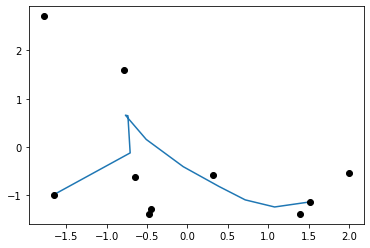

In [72]:
num_samples = 2 
dimension = 10


sample_vector = np.random.randn(num_samples, dimension)
curve = bezier.Curve.from_nodes(sample_vector)
print(sample_vector)

# plot method is only supported as dimension 2
num_pts = dimension
ax = curve.plot(num_pts=num_pts) 


ax.plot(
    sample_vector[0, :], sample_vector[1, :],
    marker="o", linestyle="None", color="black")

In [81]:
num_samples = 300 # sample 수
dimension = 100 # 차원 수


sample_vector = np.random.rand(num_samples, dimension)
curve = bezier.Curve.from_nodes(sample_vector)

curve
# plot method is only supported as dimension 2
# num_pts = degree
# ax = curve.plot(num_pts=num_pts) 

<Curve (degree=99, dimension=300)>

(300, 100)

- tangent_vec -> 각 점에서 베이지어 커브의 tanget 값
- s -> 보간율

In [193]:
dimension = 300
nodes = 100

sample_vector = np.random.rand(dimension, nodes)
print(sample_vector.shape)



curve = bezier.Curve.from_nodes(sample_vector)
print(curve)

s = 0.5 # interpolate rate
tangent_vec = curve.evaluate_hodograph(s)
print(tangent_vec.shape)
# Evaluate the tangent vector B′(s) along the curve.


from bezier.hazmat.curve_helpers import get_curvature
curvature = get_curvature(sample_vector, tangent_vec, s)
curvature


(300, 100)
<Curve (degree=99, dimension=300)>
(300, 1)


0.010367071035992883

In [195]:
tangent_vec.shape

(300, 1)

2. 베지어 곡선의 성질은 여러가지가 있는데, 대표적으로

 

1) 시작점:t=0일 때, p_0점

2) 끝점:t=1일 때, p_N점

3) 시작점에서 접선은 p_0, p_1의 변위와 평행

4) 끝점에서 접선은 p_N-1, p_N의 변위와 평행

5) 언제나 조정점들의 convex hull안에 들어간다.

6) 조정점들 중 여러 개를 같은 좌표로 설정하면, 그 부분에서 convex hull에 점점 가까워진다. 즉, 곡률이 더 심해진다.



출처: https://3dmpengines.tistory.com/784 [3DMP]

In [9]:
from bezier.hazmat.curve_helpers import evaluate_hodograph, evaluate_multi
from bezier.hazmat.curve_helpers import get_curvature
from bezier.hazmat import helpers as _py_helpers
def get_curvature(nodes, tangent_vec, s):
    """
    일단 taylor expansion의 2차항 까지 사용
    tangent -> 도합수
    concavity -> 이계도함수
    
    """
    _, num_nodes = np.shape(nodes)
    if num_nodes == 2:  # Lines have no curvature.
        return 0.0

    # NOTE: We somewhat replicate code in ``evaluate_hodograph()`` here.
    first_deriv = nodes[:, 1:] - nodes[:, :-1]
    second_deriv = first_deriv[:, 1:] - first_deriv[:, :-1]
    concavity = (
        (num_nodes - 1)
        * (num_nodes - 2)
        * evaluate_multi(second_deriv, np.asfortranarray([s]))
    )

    curvature = _py_helpers.cross_product( # ravel -> flatten느낌의 reshape
        tangent_vec.ravel(order="F"), concavity.ravel(order="F") # 분자
    )
    # NOTE: We convert to 1D to make sure NumPy uses vector norm.
    curvature /= np.linalg.norm(tangent_vec[:, 0], ord=2) ** 3 # BA
    return curvature

In [290]:
k = list()
for s in range(100):
    t = s / 100.
    k.append(get_curvature(sample_vector, tangent_vec, t))

In [293]:
sample_vector.shape

(300, 100)

In [169]:
def sample_spherical(npoints, ndim=2):
    vec = np.random.randn(ndim, npoints)/10
    vec /= np.linalg.norm(vec, axis=0)
    return vec


x,y = sample_spherical(10)
x, y = np.abs(x), np.abs(y)
# x.sort(), y.sort()
x**2 + y**2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [170]:
circle = np.array([x, y])

print(circle.shape)
curve = bezier.Curve.from_nodes(circle)
print(curve)
circle.sort(axis=1)

(2, 10)
<Curve (degree=9, dimension=2)>


<AxesSubplot:>

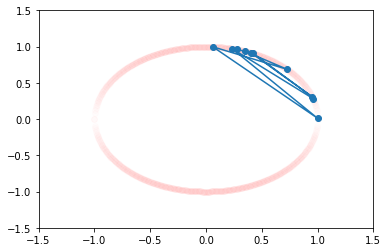

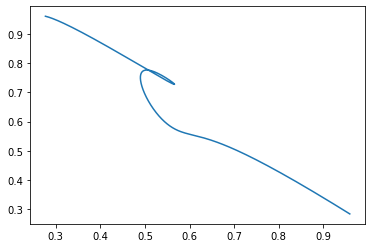

In [171]:
# x_ = np.linspace(-1, 1, 500)
# y_ = np.sqrt(1 - x_**2)
y__ = -y_
plt.scatter(x_, y_, color='r', alpha=0.01)
plt.scatter(x_, y__, color='r', alpha=0.01)

plt.scatter(x,y)
plt.plot(x,y)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
curve.plot(num_pts=500)



In [147]:
from bezier.hazmat.curve_helpers import evaluate_hodograph, evaluate_multi
from bezier.hazmat.curve_helpers import get_curvature
from bezier.hazmat import helpers as _py_helpers

k = list()
for s in range(10):
    t = s / 10.
    tangent_vec = curve.evaluate_hodograph(t)
    k.append(get_curvature(circle, tangent_vec, t))

In [148]:
k

[0.959073353860692,
 1.8631191281611235,
 3.021833828964151,
 18.94486415413074,
 61.553408134204226,
 11.671951724653841,
 0.8350045227466336,
 0.46703638065357417,
 -0.3634265966029687,
 -0.31741429752155825]

Text(0.5, 1.0, 'Bezier Approximation')

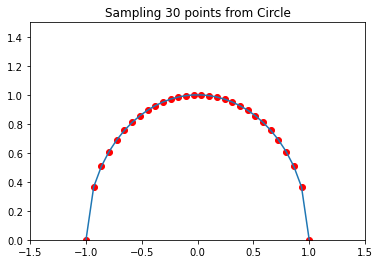

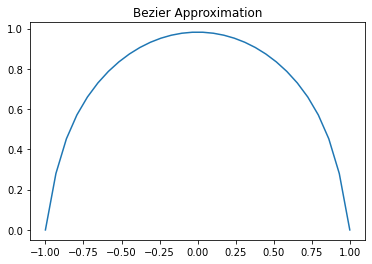

In [193]:
x = np.linspace(-1, 1, 30)
y = np.sqrt(1 - x**2)

circle = np.array([x, y])
curve = bezier.Curve.from_nodes(circle)

plt.scatter(x,y,color='r')
plt.plot(x,y)
plt.xlim([-1.5,1.5])
plt.ylim([0,1.5])
plt.title("Sampling 30 points from Circle")
curve.plot(num_pts=30)
plt.title("Bezier Approximation")

In [207]:
k = list()
num = 20
for s in range(num):
    t = s / num
    tangent_vec = curve.evaluate_hodograph(t)
    k.append(get_curvature(circle, tangent_vec, t))
    print("The curvature {:.3f} at t = {:.2f}".format(abs(k[s]), t))
    


The curvature 0.290 at t = 0.00
The curvature 0.782 at t = 0.05
The curvature 1.083 at t = 0.10
The curvature 1.096 at t = 0.15
The curvature 1.055 at t = 0.20
The curvature 1.033 at t = 0.25
The curvature 1.025 at t = 0.30
The curvature 1.022 at t = 0.35
The curvature 1.021 at t = 0.40
The curvature 1.020 at t = 0.45
The curvature 1.020 at t = 0.50
The curvature 1.020 at t = 0.55
The curvature 1.021 at t = 0.60
The curvature 1.022 at t = 0.65
The curvature 1.025 at t = 0.70
The curvature 1.033 at t = 0.75
The curvature 1.055 at t = 0.80
The curvature 1.096 at t = 0.85
The curvature 1.083 at t = 0.90
The curvature 0.782 at t = 0.95


float